In [1]:
# GAN corrigido com saída linear no Generator + Reescalonamento para RSSI

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Input, Model
import matplotlib.pyplot as plt


2025-05-22 05:15:36.498896: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 05:15:36.521665: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 05:15:36.546040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747905336.577993  164270 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747905336.588594  164270 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747905336.629828  164270 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:

# ================================
# 1. Dados reais de entrada (X_real)
# ================================
df_real = pd.read_csv("/home/darkcover/Documentos/Gan/Data/df_simulated.csv")
X_real = df_real.iloc[:, :10].values.astype(np.float32)

n_features = X_real.shape[1]  # 10 WAPs
latent_dim = n_features       # 10


In [3]:

# ================================
# 2. Construir o Generator (1 camada oculta de 10 neurônios, saída linear)
# ================================
def build_generator():
    inp = Input(shape=(latent_dim,))
    x = layers.Dense(10, activation='relu')(inp)
    out = layers.Dense(n_features, activation='linear')(x)  # Saída linear
    return Model(inp, out, name="Generator")

In [4]:

# ================================
# 3. Construir o Discriminator (1 camada oculta de 10 neurônios, saída sigmoid)
# ================================
def build_discriminator():
    inp = Input(shape=(n_features,))
    x = layers.Dense(10, activation='relu')(inp)
    out = layers.Dense(1, activation='sigmoid')(x)  # Saída sigmoid
    return Model(inp, out, name="Discriminator")


In [5]:

# ================================
# 4. Montar e Compilar o GAN
#    - Discriminator: loss='binary_crossentropy', optimizer=Adam(0.01)
#    - Generator: loss='binary_crossentropy', optimizer=Adam(0.01)
#    - GAN: loss='binary_crossentropy', optimizer=Adam(0.01)
# ================================
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(
            optimizer=tf.keras.optimizers.Adam(0.01),
            loss='binary_crossentropy')

discriminator.trainable = False # Durante o treino do Gan, mantém D fixo

# Montar o GAN
gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output, name="GAN")
# Compilar o GAN
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01))


2025-05-22 05:15:42.439737: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
# ================================
# 5. Loop de Treinamento GAN
# ================================
epochs = 200
batch_size = 100
half_batch = batch_size // 2
d_losses, g_losses = [], []

for epoch in range(1,epochs+1):
    # 5.1 Treina D com amostras reais
    idx = np.random.randint(0, X_real.shape[0], half_batch)
    real_samples = X_real[idx]
    real_labels = np.ones((half_batch, 1))
    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    
    # 5.2 Treina D com amostras falsas
    noise = np.random.uniform(-1, 1, (half_batch, latent_dim))
    fake_samples = generator.predict(noise, verbose=0)
    fake_labels = np.zeros((half_batch, 1))
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    
    # 5.3 Treina G
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs} | D_loss: {d_loss:.4f} | G_loss: {g_loss:.4f}")


/home/darkcover/.cache/pypoetry/virtualenvs/gan-oPyfrVEv-py3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 20/200 | D_loss: 0.8818 | G_loss: 0.2500
Epoch 40/200 | D_loss: 1.4762 | G_loss: 0.1388
Epoch 60/200 | D_loss: 1.9547 | G_loss: 0.0943
Epoch 80/200 | D_loss: 2.2662 | G_loss: 0.0714
Epoch 100/200 | D_loss: 2.4929 | G_loss: 0.0575
Epoch 120/200 | D_loss: 2.6640 | G_loss: 0.0481
Epoch 140/200 | D_loss: 2.8038 | G_loss: 0.0414
Epoch 160/200 | D_loss: 2.9179 | G_loss: 0.0364
Epoch 180/200 | D_loss: 3.0157 | G_loss: 0.0324
Epoch 200/200 | D_loss: 3.1053 | G_loss: 0.0292


In [7]:
# Salvar Generator e Discriminator
generator.save("/home/darkcover/Documentos/Gan/Models/Modelsgenerator.keras")
discriminator.save("/home/darkcover/Documentos/Gan/Models/Modelsdiscriminator.keras")
print("✅ Generator e Discriminator salvos em models/")


✅ Generator e Discriminator salvos em models/


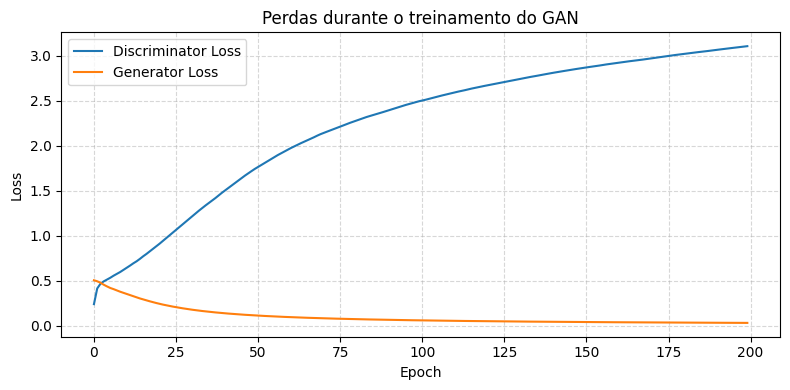

In [8]:

# ================================
# 6. Plotar perdas
# ================================
plt.figure(figsize=(8, 4))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Perdas durante o treinamento do GAN")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
# 7. Geração de 10 blocos de 4.000 - 40.000 amostras sintéticas
mf_blocks = 10
samples_per_block = 4000
generated_blocks = []

for _ in range(mf_blocks):
    noise_block = np.random.uniform(-1, 1, size=(samples_per_block, latent_dim))
    raw_block = generator.predict(noise_block, verbose=0)
    generated_blocks.append(raw_block)
    print(f"Bloco de {samples_per_block} amostras gerado com sucesso")

# Concatenar os blocos gerados
generated_raw = np.vstack(generated_blocks)
# Reescalonamento para RSSI
min_raw, max_raw = generated_raw.min(), generated_raw.max()
scaled = (generated_raw - min_raw) / (max_raw - min_raw)
rssi = scaled * 70 - 110

columns = [f"WAP{str(i+1).zfill(3)}" for i in range(n_features)]
df_generated = pd.DataFrame(np.round(rssi).astype(int), columns=columns)
df_generated = df_generated.clip(lower=-110, upper=-40)

Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso


In [10]:
df_generated.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,-82.669750,-87.583075,-83.166675,-64.436850,-77.422775,-65.518300,-62.587850,-84.667550,-84.010225,-53.125425
std,3.299054,4.379438,3.785558,3.356232,2.458818,3.493196,3.595811,2.772124,3.642163,2.913470
min,-97.000000,-110.000000,-98.000000,-72.000000,-89.000000,-75.000000,-74.000000,-98.000000,-100.000000,-61.000000
25%,-85.000000,-90.000000,-86.000000,-67.000000,-79.000000,-68.000000,-65.000000,-86.000000,-86.000000,-55.000000
50%,-82.000000,-87.000000,-83.000000,-65.000000,-77.000000,-66.000000,-63.000000,-84.000000,-84.000000,-53.000000
75%,-80.000000,-84.000000,-80.000000,-62.000000,-76.000000,-63.000000,-60.000000,-83.000000,-81.000000,-51.000000
max,-74.000000,-76.000000,-73.000000,-51.000000,-71.000000,-52.000000,-47.000000,-77.000000,-73.000000,-40.000000


In [11]:
df_generated.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010
0,-80,-85,-82,-66,-75,-70,-64,-84,-85,-55
1,-84,-87,-85,-63,-79,-64,-61,-82,-82,-53
2,-80,-92,-87,-66,-75,-69,-68,-86,-83,-51
3,-84,-86,-80,-68,-77,-70,-65,-85,-82,-56
4,-95,-89,-92,-54,-85,-57,-51,-88,-94,-44


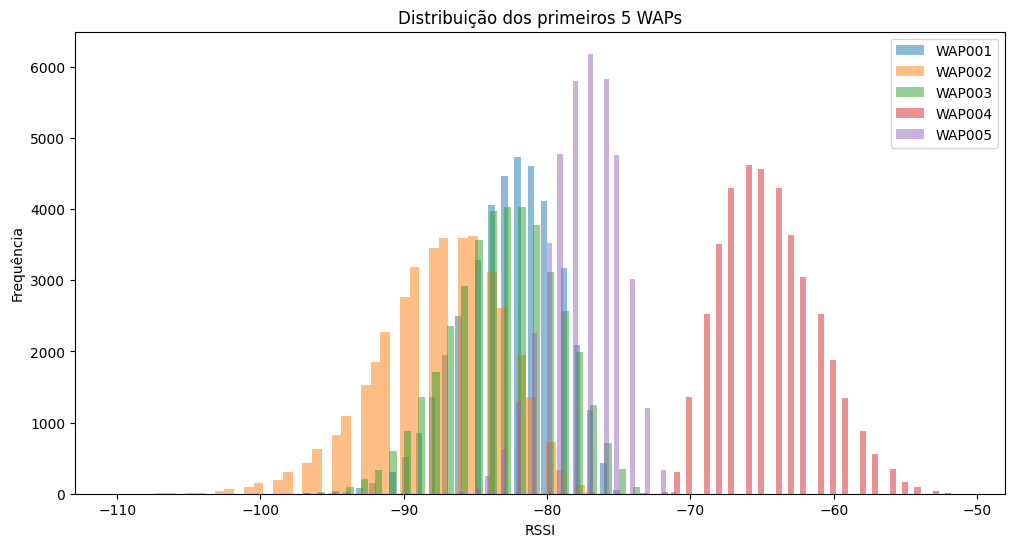

In [12]:
# Exemplo de histograma para os primeiros 5 WAPs
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.hist(df_generated.iloc[:, i], bins=50, alpha=0.5, label=columns[i])
plt.title("Distribuição dos primeiros 5 WAPs")
plt.xlabel("RSSI")
plt.ylabel("Frequência")
plt.legend()
plt.tight_layout
plt.show()

In [13]:

df_generated.to_csv("/home/darkcover/Documentos/Gan/Data/df_generated.csv", index=False)
print("df_generated.csv salvo com sucesso com RSSI reescalonado")


df_generated.csv salvo com sucesso com RSSI reescalonado


/home/darkcover/.cache/pypoetry/virtualenvs/gan-oPyfrVEv-py3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 20/200 | D_loss: 16.1456 | G_loss: 0.2029
Epoch 40/200 | D_loss: 17.3975 | G_loss: 0.1028
Epoch 60/200 | D_loss: 17.9876 | G_loss: 0.0688
Epoch 80/200 | D_loss: 18.3297 | G_loss: 0.0517
Epoch 100/200 | D_loss: 18.5442 | G_loss: 0.0414
Epoch 120/200 | D_loss: 18.7179 | G_loss: 0.0346
Epoch 140/200 | D_loss: 18.8483 | G_loss: 0.0297
Epoch 160/200 | D_loss: 18.9270 | G_loss: 0.0260
Epoch 180/200 | D_loss: 19.0156 | G_loss: 0.0231
Epoch 200/200 | D_loss: 19.0774 | G_loss: 0.0208
Generator e Discriminator salvos em Models/


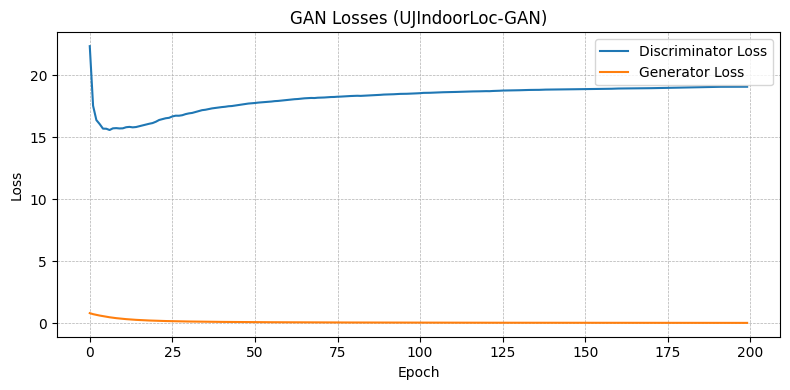

df_generated_UJIndoorLoc.csv salvo com sucesso


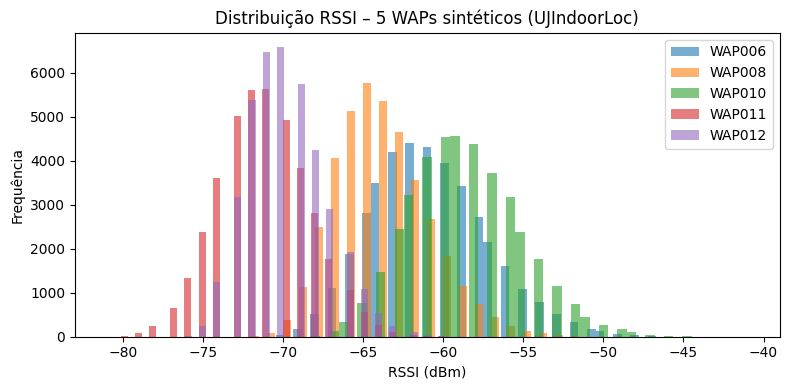

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. Carregar e pré-processar UJIndoorLoc (B1–F2)
# --------------------------------------------------
df_full = pd.read_csv("/home/darkcover/Documentos/Gan/Data/Real/trainingData.csv")
# Substituir missing=100 por -110 dBm
wap_cols = [c for c in df_full.columns if c.startswith("WAP")]
df_full[wap_cols] = df_full[wap_cols].replace(100, -110)
# Filtrar Building 1, Floor 2
df_env = df_full[(df_full.BUILDINGID == 1) & (df_full.FLOOR == 2)].copy()
# Selecionar apenas WAPs detectados ao menos uma vez (~190 colunas)
present_waps = [c for c in wap_cols if (df_env[c] != -110).any()]
X_real = df_env[present_waps].astype(np.float32).values

n_features = X_real.shape[1]   # ≈190 WAPs
latent_dim  = n_features

# --------------------------------------------------
# 2. Construir Generator e Discriminator
# --------------------------------------------------
def build_generator():
    inp = Input(shape=(latent_dim,))
    x   = layers.Dense(10, activation='relu')(inp)
    out = layers.Dense(n_features, activation='linear')(x)
    return Model(inp, out, name="Generator")

def build_discriminator():
    inp = Input(shape=(n_features,))
    x   = layers.Dense(10, activation='relu')(inp)
    out = layers.Dense(1, activation='sigmoid')(x)
    return Model(inp, out, name="Discriminator")

generator     = build_generator()
discriminator = build_discriminator()

discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss='binary_crossentropy'
)

# --------------------------------------------------
# 3. Montar e compilar o GAN
# --------------------------------------------------
discriminator.trainable = False
gan_input  = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan        = Model(gan_input, gan_output, name="GAN")
gan.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss='binary_crossentropy'
)

# --------------------------------------------------
# 4. Treinamento do GAN
# --------------------------------------------------
epochs     = 200
batch_size = 100
half_batch = batch_size // 2

d_losses = []
g_losses = []

for epoch in range(1, epochs+1):
    # 4.1) Treina D com reais
    idx          = np.random.randint(0, X_real.shape[0], half_batch)
    real_batch   = X_real[idx]
    d_loss_real  = discriminator.train_on_batch(real_batch, np.ones((half_batch,1)))
    # 4.2) Treina D com falsos
    noise        = np.random.uniform(-1,1,(half_batch, latent_dim))
    fake_batch   = generator.predict(noise, verbose=0)
    d_loss_fake  = discriminator.train_on_batch(fake_batch, np.zeros((half_batch,1)))
    d_loss       = 0.5*(d_loss_real + d_loss_fake)
    # 4.3) Treina G via GAN
    noise        = np.random.uniform(-1,1,(batch_size, latent_dim))
    g_loss       = gan.train_on_batch(noise, np.ones((batch_size,1)))
    
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs} | D_loss: {d_loss:.4f} | G_loss: {g_loss:.4f}")

# --------------------------------------------------
# 5. Salvar modelos
# --------------------------------------------------
generator.save("/home/darkcover/Documentos/Gan/Models/generator_phase2_UJ.keras")
discriminator.save("/home/darkcover/Documentos/Gan/Models/discriminator_phase2_UJ.keras")
print("Generator e Discriminator salvos em Models/")

# --------------------------------------------------
# 6. Plotagem das perdas
# --------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("GAN Losses (UJIndoorLoc-GAN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 7. Geração de ~40 000 amostras sintéticas
# --------------------------------------------------
mf_blocks         = 10
samples_per_block = 4000
generated_blocks  = []

for _ in range(mf_blocks):
    noise_block = np.random.uniform(-1,1,(samples_per_block, latent_dim))
    block       = generator.predict(noise_block, verbose=0)
    generated_blocks.append(block)

generated_raw = np.vstack(generated_blocks)

# --------------------------------------------------
# 8. Reescalonamento para RSSI em [-110, -40]
# --------------------------------------------------
min_raw, max_raw = generated_raw.min(), generated_raw.max()
scaled = (generated_raw - min_raw) / (max_raw - min_raw)
rssi   = scaled * 70 - 110

df_generated = pd.DataFrame(
    np.round(rssi).astype(int),
    columns=present_waps
).clip(-110, -40)

df_generated.to_csv("/home/darkcover/Documentos/Gan/Data/df_generated_UJIndoorLoc.csv", index=False)
print("df_generated_UJIndoorLoc.csv salvo com sucesso")

# --------------------------------------------------
# 9. Validação rápida (histograma 5 primeiros WAPs)
# --------------------------------------------------
plt.figure(figsize=(8,4))
for wap in present_waps[:5]:
    plt.hist(df_generated[wap], bins=50, alpha=0.6, label=wap)
plt.title("Distribuição RSSI – 5 WAPs sintéticos (UJIndoorLoc)")
plt.xlabel("RSSI (dBm)")
plt.ylabel("Frequência")
plt.legend()
plt.tight_layout()
plt.show()
